# Pan Fetal Immune - Evaluate batch correction

Use metrics from [scIB](https://github.com/theislab/scib) and [scPOP](https://github.com/vinay-swamy/scPOP) to select the best integration strategy

In [3]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import anndata

In [4]:
from scIB import metrics

In [ ]:
# ## import utils
# cwd = '../utils/'
# sys.path.append(cwd)

# import genes
# import panfetal_utils

### Load data and embeddings

In [35]:
adata = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.h5ad')

Read obs

In [36]:
anno_obs = pd.read_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.full_obs.annotated.csv", index_col=0)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (9,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [37]:
adata.obs = anno_obs.loc[adata.obs_names]

... storing 'Sample' as categorical
... storing 'donor' as categorical
... storing 'organ' as categorical
... storing 'file' as categorical
... storing 'predicted_doublets' as categorical
... storing 'name' as categorical
... storing 'batch' as categorical
... storing 'bbk' as categorical
... storing 'uniform_label' as categorical
... storing 'uniform_label_expanded_merged' as categorical
... storing 'uniform_label_lvl0' as categorical
... storing 'Sample.lanes' as categorical
... storing 'Sort_id' as categorical
... storing 'method' as categorical
... storing 'sex' as categorical
... storing 'Processing_method' as categorical
... storing 'AnnatomicalPart' as categorical
... storing 'anno_lvl_1_LYMPHOID' as categorical
... storing 'anno_lvl_2_LYMPHOID' as categorical
... storing 'anno_lvl_1_MYELOID' as categorical
... storing 'anno_lvl_2_MYELOID' as categorical
... storing 'anno_lvl_1_MEM_PROGENITORS' as categorical
... storing 'anno_lvl_2_MEM_PROGENITORS' as categorical


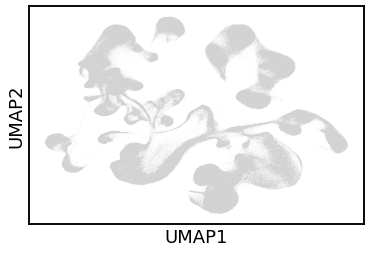

In [38]:
sc.pl.umap(adata)

In [10]:
help(metrics.graph_connectivity)

Help on function graph_connectivity in module scIB.metrics:

graph_connectivity(adata_post, label_key)
    "
    Metric that quantifies how connected the subgraph corresponding to each batch cluster is.



In [12]:
metrics.graph_connectivity(adata, label_key="uniform_label_lvl0")

0.8276166891580511

In [26]:
adata.obs["leiden_150"] = adata.obs["leiden_150"].astype("category")

In [29]:
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score
normalized_mutual_info_score(adata.obs['uniform_label_lvl0'], adata.obs["leiden_150"])

0.4544524506344005

In [15]:
metrics.ari(adata, group1="uniform_label_lvl0", group2="leiden_150")

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))


-11.246425724113548

In [13]:
help(metrics.ari)

Help on function ari in module scIB.metrics:

ari(adata, group1, group2)
    params:
        adata: anndata object
        group1: ground-truth cluster assignments (e.g. cell type labels)
        group2: "predicted" cluster assignments
    The function is symmetric, so group1 and group2 can be switched



### Load scVI embedding

In [44]:
emb_file = "/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/PAN.A01.v01.entire_data_raw_count.wGut.scVI_out.5000HVGS.removeCC.keepTCRBCR.10ldims.npy"
# X_scVI_emb = np.load(emb_file)


'/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/PAN.A01.v01.entire_data_raw_count.wGut.scVI_out.5000HVGS.removeCC.keepTCRBCR.10ldims.UMAP.npy'

In [6]:
X_scVI_emb2 = np.load("/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/PAN.A01.v01.entire_data_raw_count.wGut.scVI_out.5000HVGS.removeCC.removeTCRBCR.10ldims.npy")

In [30]:
import seaborn as sns
cormat = np.corrcoef(X_scVI_emb.T, X_scVI_emb2.T)[0:10,10:20]

In [39]:
def embed_and_cluster_scvi(emb_file):
    X_scVI_emb = np.load(emb_file)
    adata.obsm["X_scvi"] = X_scVI_emb
    sc.pp.neighbors(adata, use_rep = "X_scvi", n_neighbors = 30, key_added="scvi")
    ## UMAP
    sc.tl.umap(adata, min_dist = 0.01, spread = 2, neighbors_key="scvi")
    np.save(emb_file.rstrip(".npy") + ".UMAP.npy", adata.obsm["X_umap"])
    ## Clustering 
    sc.tl.leiden(adata, resolution=1.5, key_added='leiden_150', n_iterations=5)
    adata.obs[["leiden_150"]].to_csv(emb_file.rstrip(".npy") + "clustering.csv")

AnnData object with n_obs × n_vars = 897341 × 3195
    obs: 'Sample', 'n_counts', 'n_genes', 'donor', 'organ', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'batch', 'bbk', 'uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0', 'Sample.lanes', 'Sort_id', 'age', 'method', 'sex', 'Processing_method', 'AnnatomicalPart', 'leiden_100', 'leiden_150', 'isin_split_NKT', 'isin_split_B_CLEAN', 'isin_split_MYELOID_LYMPHOID', 'isin_split_STROMA', 'isin_split_MYELOID_CLEAN', 'isin_split_LYMPHOID', 'isin_split_MEM_PROGENITORS', 'anno_lvl_1_LYMPHOID', 'anno_lvl_2_LYMPHOID', 'anno_lvl_1_MYELOID', 'anno_lvl_2_MYELOID', 'anno_lvl_1_MEM_PROGENITORS', 'anno_lvl_2_MEM_PROGENITORS', 'is_annotated', 'is_uniquely_annotated'
    var: 'GeneName', 'GeneID', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'method_colors', 'neighbors', 'organ_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_old', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
sc.pp.neighbors(adata, use_rep = "X_scvi", n_neighbors = 30, key_added="scvi")
## UMAP
sc.tl.umap(adata, min_dist = 0.01, spread = 2, neighbors_key="scvi")
np.save(emb_file.rstrip(".npy") + ".UMAP.npy", adata.obsm["X_umap"])
## Clustering 
sc.tl.leiden(adata, resolution=1.5, key_added='leiden_150', n_iterations=5)
adata.obs[["leiden_150"]].to_csv(emb_file.rstrip(".npy") + "clustering.csv")

In [1]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import anndata


In [3]:
h5ad_file = '/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.h5ad'
emb_file = "/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/PAN.A01.v01.entire_data_raw_count.wGut.scVI_out.5000HVGS.removeCC.keepTCRBCR.10ldims.npy"

In [4]:
## Read adata
adata = sc.read_h5ad(h5ad_file)

In [5]:
def embed_and_cluster_scvi(adata, emb_file):
    X_scVI_emb = np.load(emb_file)
    adata.obsm["X_scvi"] = X_scVI_emb
    print("Computing KNN graph...")
    sc.pp.neighbors(adata, use_rep = "X_scvi", n_neighbors = 30, key_added="scvi")
    ## UMAP
    print("Computing UMAP...")
    sc.tl.umap(adata, min_dist = 0.01, spread = 2, neighbors_key="scvi")
    np.save(emb_file.rstrip(".npy") + ".UMAP.npy", adata.obsm["X_umap"])
    ## Clustering 
    print("Clustering...")
    sc.tl.leiden(adata, resolution=1.5, key_added='leiden_150', n_iterations=5)
    adata.obs[["leiden_150"]].to_csv(emb_file.rstrip(".npy") + "clustering.csv")

In [6]:
embed_and_cluster_scvi(adata, emb_file)

Computing KNN graph...


KeyboardInterrupt: 